In [ ]:
import pandas as pd
import numpy as np
import seaborn as ans
import matplotlib.pyplot as plt
import statsmodels.api as sm

!pip install pmdarima
!pip install kneed
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from kneed import DataGenerator, KneeLocator
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')


# *Membuka data yang akan digunakan *

In [ ]:
df_customer = pd.read_csv(r'/content/Customer.csv',delimiter = ';')
df_product = pd.read_csv(r'/content/Product.csv',delimiter = ';')
df_store = pd.read_csv(r'/content/Store.csv',delimiter = ';')
df_transaction = pd.read_csv(r'/content/Transaction.csv',delimiter = ';')

# **Data Cleansing**
  Fungsi utama dari data cleansing adalah untuk membersihkan, memperbaiki, dan mempersiapkan data agar dapat digunakan dalam analisis dan pemodelan.

Berikut beberapa tujuan utama dari data cleansing
1.   Menghilangkan Noise
2.   Mengisi Data yang Hilang
3.   Standarisasi Data
4.   Validasi Data
5.   Mengubah tipe data
6.   Memeriksa konsistensi data
7.   Mengatasi data duplikat




In [ ]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [ ]:
# proses melakukan data cleansing
# data cleansing pada df_customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.',regex=True).astype('float')

# data clensing pada df_store
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.',regex=True).astype('float')

# data cleansing pada df_transaction
df_transaction['Date']= pd.to_datetime(df_transaction['Date'])
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


# **Gabungkan semua data**

In [ ]:
df_merge = pd.merge(df_transaction,df_customer, on = ['CustomerID'])
df_merge = pd.merge(df_merge,df_product.drop(columns=['Price']),on=['ProductID'])
df_merge = pd.merge(df_merge,df_store,on=['StoreID'])
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


# **Membuat Model Mechine Learning (time series)**

Model Machine learning Time Series yang akan digunakan yaitu ARIMA (AutoRegressive Integrated Moving Average) adalah salah satu metode analisis statistik yang digunakan untuk memodelkan dan meramalkan data deret waktu. model ARIMA ynag digunakan model ARIMA (p, d, q), di mana:

1. p adalah orde autoregresif, yang mengindikasikan berapa banyak nilai sebelumnya yang akan digunakan dalam model AR.
2. d adalah orde diferensiasi, yang mengindikasikan berapa kali diferensiasi yang diperlukan untuk menjadikan deret waktu stasioner.
3. q adalah orde moving average, yang mengindikasikan berapa banyak nilai gangguan acak sebelumnya yang akan digunakan dalam model MA.

Proses membangun model ARIMA melibatkan pemilihan nilai-nilai p, d, dan q yang paling sesuai untuk data deret waktu tertentu, pelatihan model dengan data historis, dan kemudian menggunakan model tersebut untuk meramalkan nilai-nilai masa depan.

In [ ]:
#model regresi time series arima
df_regresi = df_merge.groupby('Date').agg({'Qty':'sum'}).reset_index()
df_regresi.head()


,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67


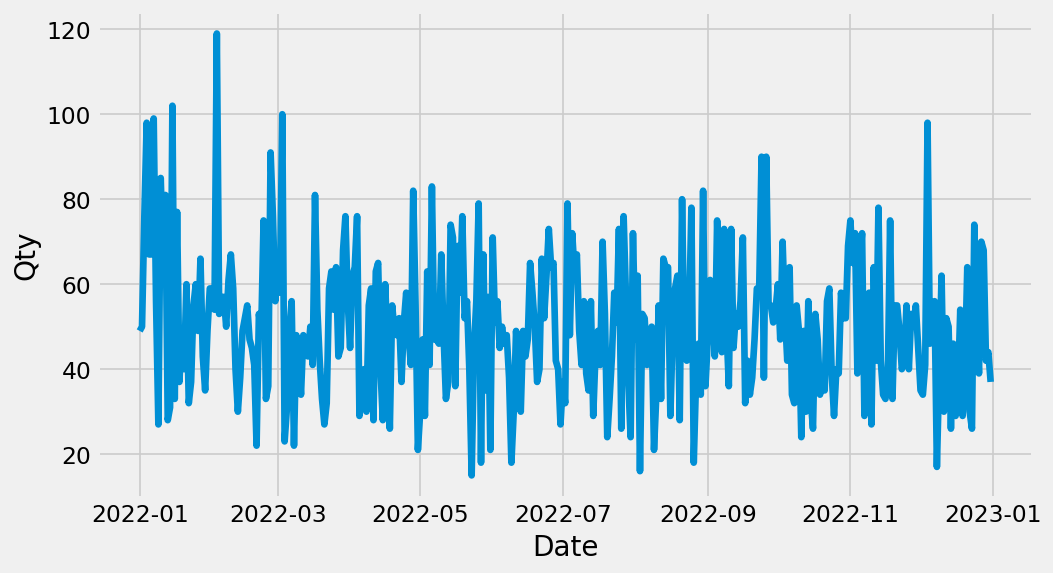

In [ ]:
# plot time series dalam 1 tahun dari bulan ke bulan
fig, ax = plt.subplots(figsize=(9, 5))
ans.lineplot(x = 'Date', y = 'Qty', data= df_regresi)
plt.tight_layout()

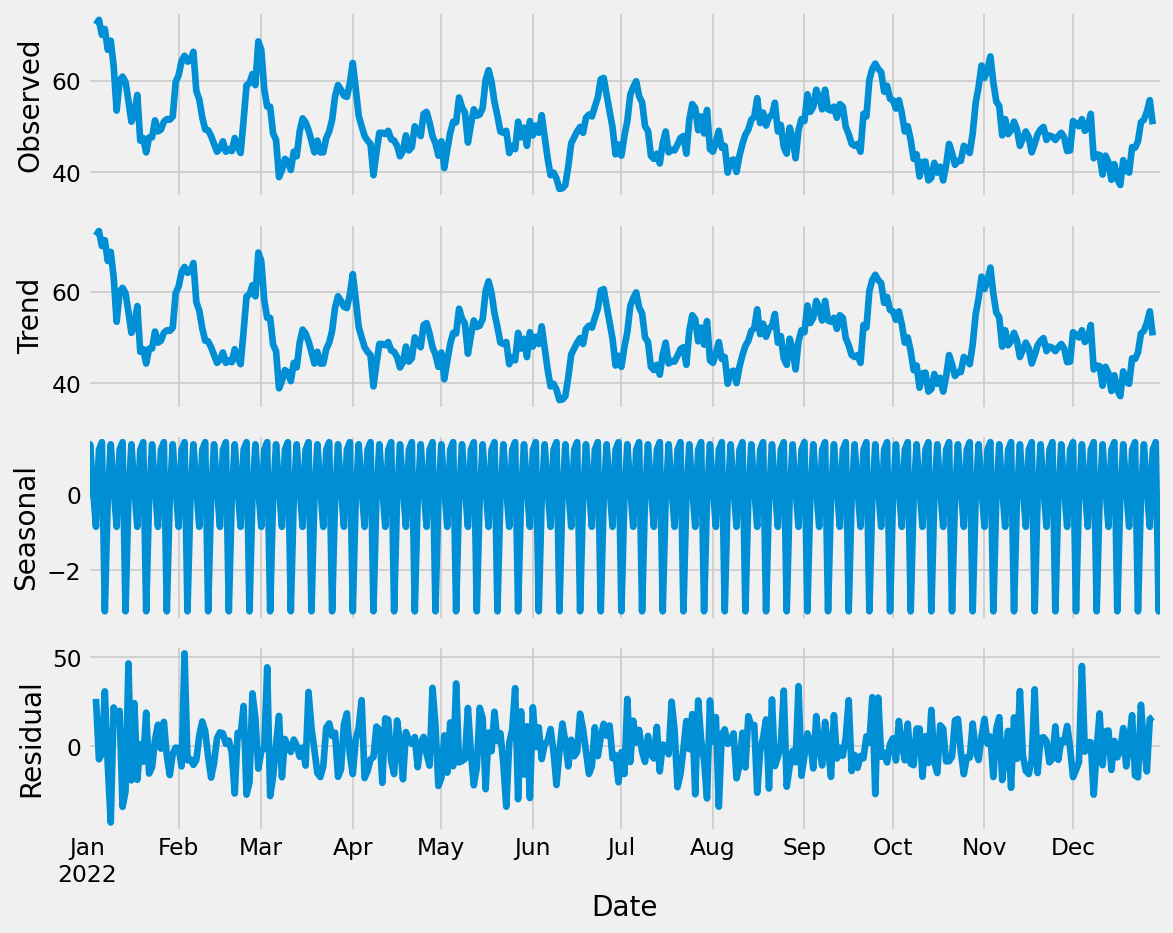

In [ ]:
train_data_index = df_regresi.set_index('Date')
regresi_decomposition = seasonal_decompose(train_data_index)

# plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
regresi_decomposition.trend.plot(ax=ax1)
ax1.set_ylabel('Observed')

regresi_decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

regresi_decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

regresi_decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# *Mengecek stasioner data menggunakan (Augmented Dickey-Fuller test) *
  Augmented Dickey-Fuller (ADF) test adalah sebuah tes statistik yang digunakan untuk menguji apakah suatu deret waktu stasioner atau tidak. Dalam konteks pengujian stasioneritas, konsep stasioneritas mengacu pada deret waktu yang statistikanya tetap atau tidak berubah sepanjang waktu. ADF test adalah salah satu alat penting dalam analisis deret waktu, terutama dalam pemodelan time series seperti ARIMA (AutoRegressive Integrated Moving Average).

In [ ]:
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

    # Interpret the results
if result[1] <= 0.05:
  print("The data is stationary (reject the null hypothesis)")
else:
  print("The data is non-stationary (fail to reject the null hypothesis)")



ADF Statistic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
The data is stationary (reject the null hypothesis)


**Mencari Nilai P dan Q untuk model ARIMA**

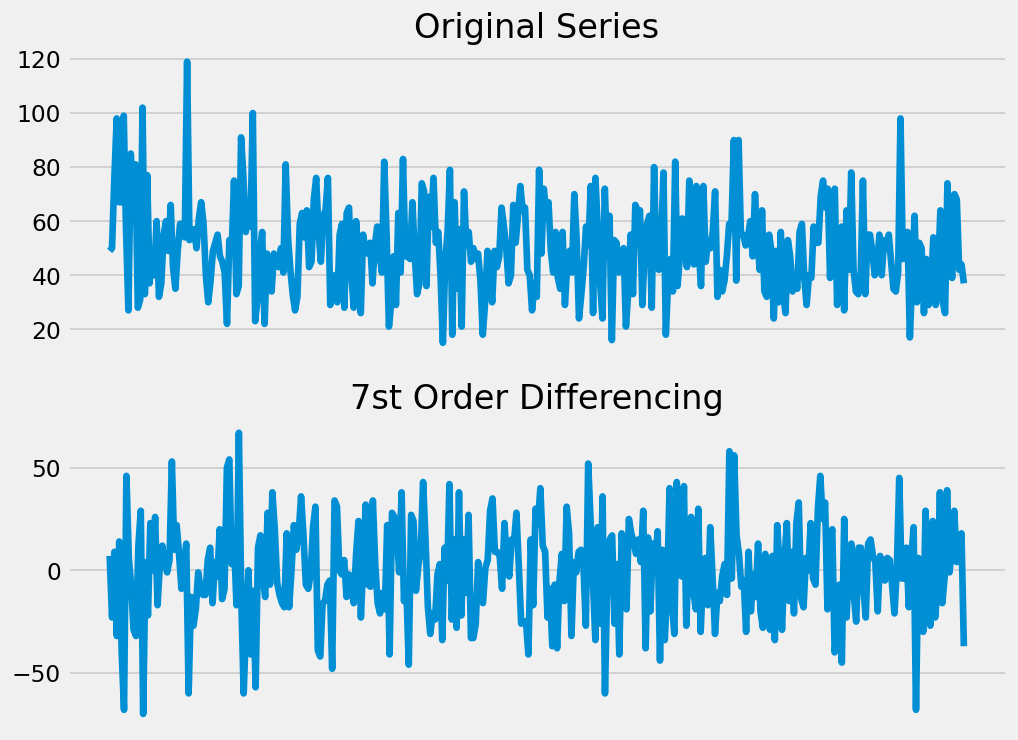

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df_regresi.Qty); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_regresi.Qty.diff(periods = 7)); ax2.set_title('7st Order Differencing'); ax2.axes.xaxis.set_visible(False)

plt.show()

# **Mencari nilai P menggunakan PACF dan Q menggunkan ACF**
ACF (Autocorrelation Function) dan PACF (Partial Autocorrelation Function)



*   Plot ACF: ACF adalah grafik fungsi korelasi antara nilai-nilai dalam deret waktu dengan nilai-nilai sebelumnya dalam deret waktu. Plot ACF dapat membantu mengidentifikasi orde autoregresif yang potensial. Dalam plot ACF, puncak-puncak yang melampaui area bayangan adalah indikasi dari orde autoregresif yang mungkin. Orde autoregresif adalah jumlah lag (nilai-nilai sebelumnya) yang signifikan dalam plot ACF.
*   Plot PACF: PACF adalah grafik fungsi korelasi parsial yang memeriksa hubungan antara dua titik dalam deret waktu dengan mengontrol semua lag yang berada di antara keduanya. Plot PACF membantu lebih mempersempit nilai p yang mungkin. Orde autoregresif yang signifikan dalam plot PACF adalah nilai p yang potensial.
*   Setelah melakukan plot ACF dan PACF,dapat mulai eksplorasi berbagai nilai p untuk membangun beberapa model ARIMA dengan orde yang berbeda. menggunakan alat statistik atau perangkat lunak seperti Python dengan paket seperti Statsmodels atau R untuk menghitung model ARIMA dengan nilai p yang berbeda dan membandingkannya.




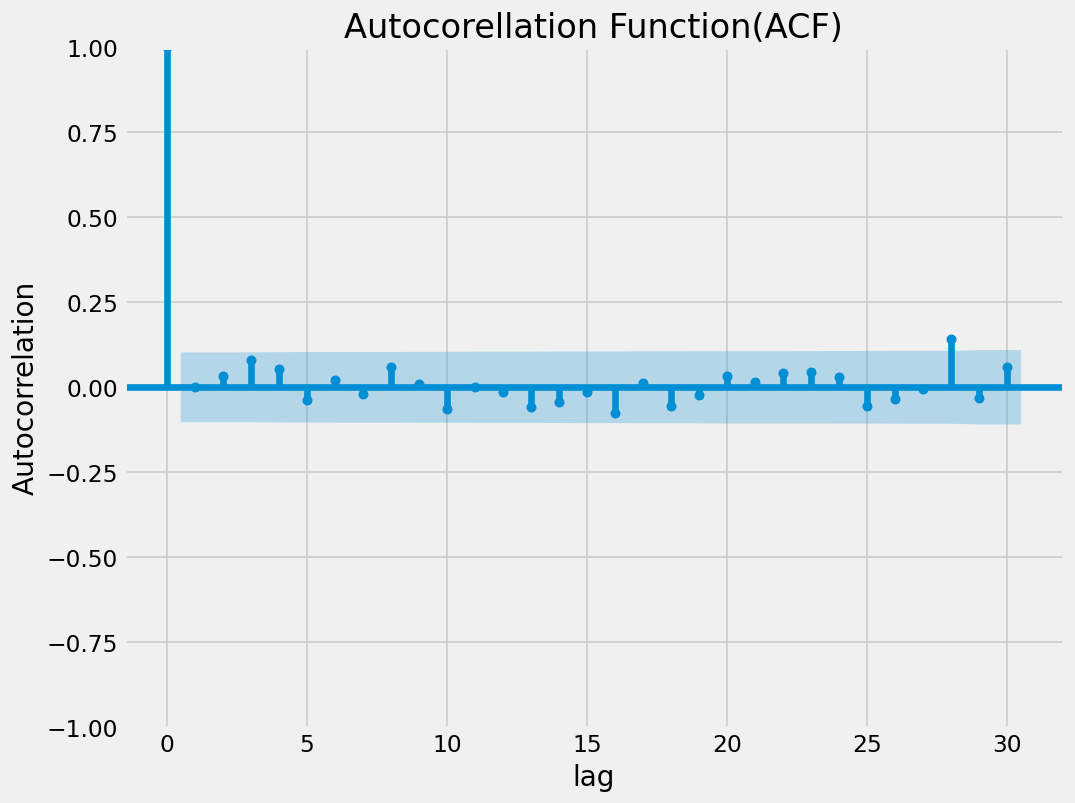

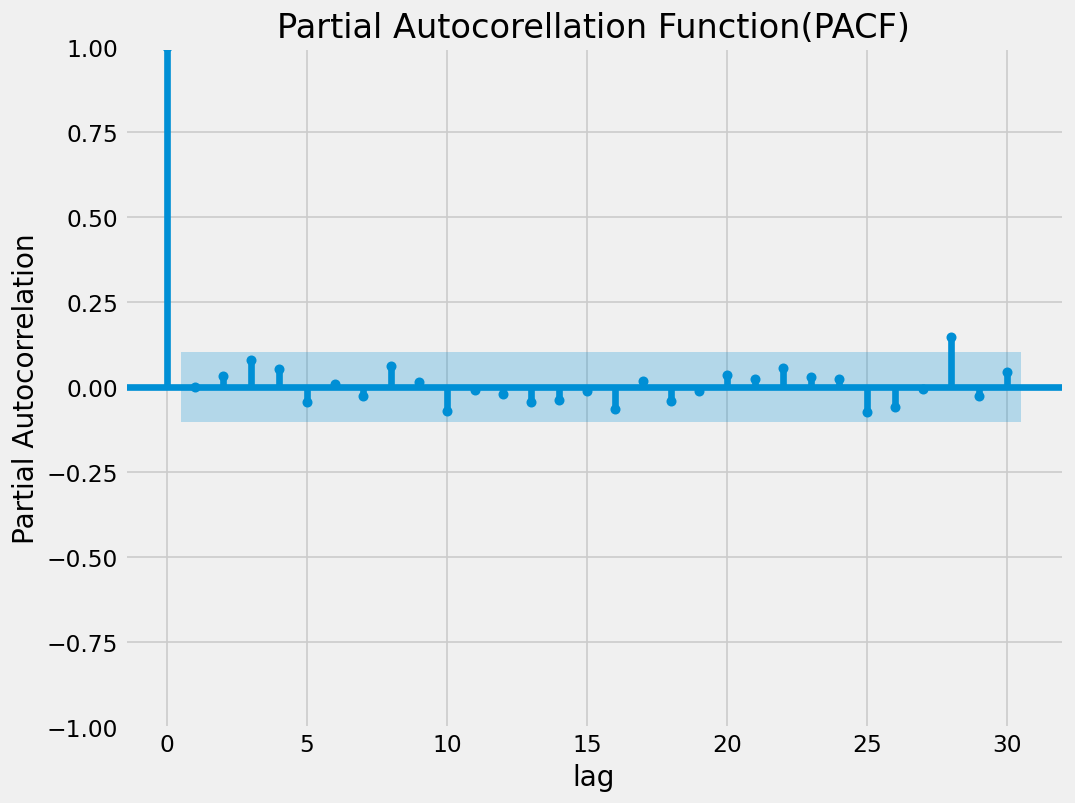

In [ ]:
# menggunakan Data Original
plot_acf(df_regresi['Qty'].dropna(),lags=30)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorellation Function(ACF)')
plt.show()
# plot PACF
plot_pacf(df_regresi['Qty'].dropna(),lags=30)
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorellation Function(PACF)')
plt.show()

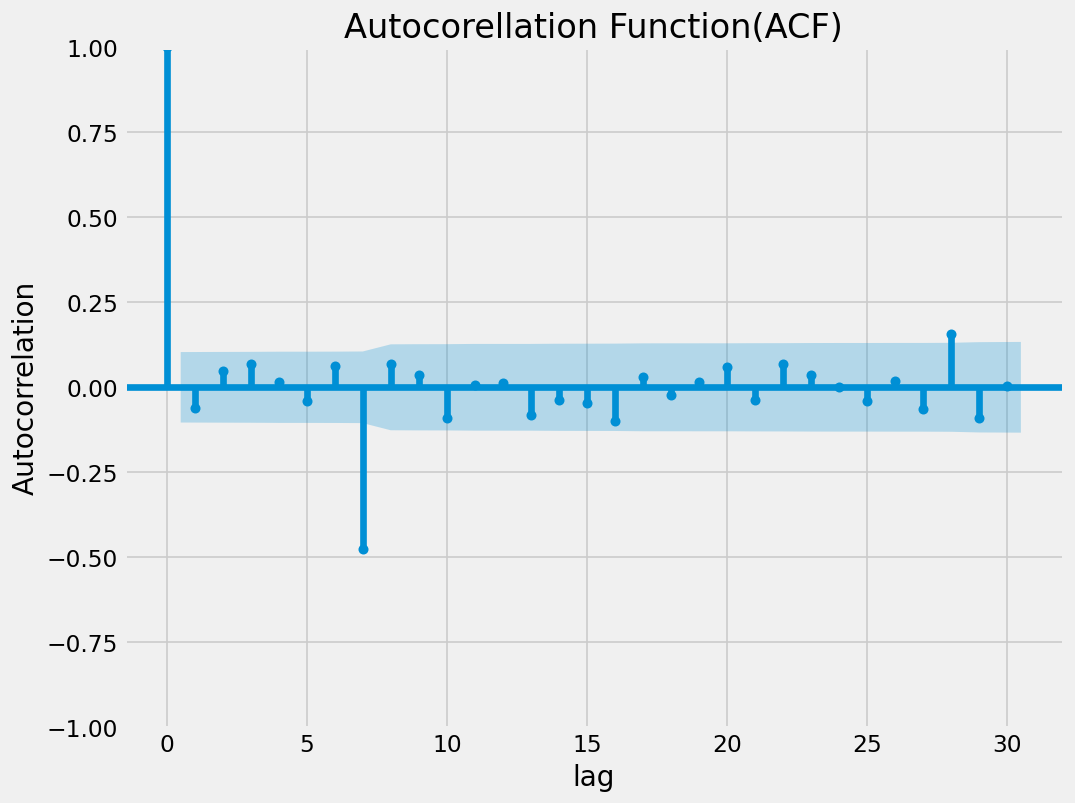

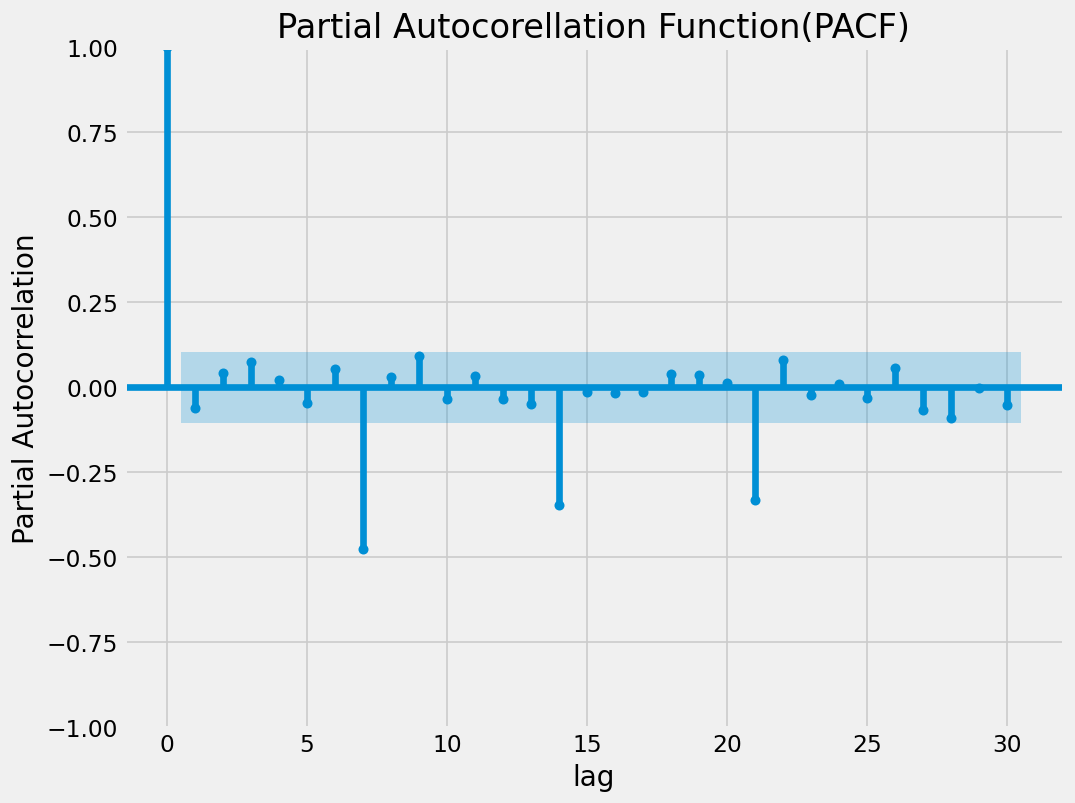

In [ ]:
# Menggunakn data yang sudah di Differencing
plot_acf(df_regresi.Qty.diff(periods = 7).dropna(),lags=30)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorellation Function(ACF)')
plt.show()
# plot PACF
plot_pacf(df_regresi.Qty.diff(periods = 7).dropna(),lags=30)
plt.xlabel('lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorellation Function(PACF)')
plt.show()

In [ ]:
df_regresi.head

<bound method NDFrame.head of           Date  Qty
0   2022-01-01   49
1   2022-01-02   50
2   2022-01-03   76
3   2022-01-04   98
4   2022-01-05   67
..         ...  ...
360 2022-12-27   70
361 2022-12-28   68
362 2022-12-29   42
363 2022-12-30   44
364 2022-12-31   37

[365 rows x 2 columns]>

Menggunakn auto arima sebagai perbandingan untuk menentunkan nilai orde yang paling sesuai untuk digunakan dapat dilihat nilai orde yang digunakan yaitu (,0,0,0) (2,1,1,7) meruapakan nilai terbaik yang dapat digunakan.

In [ ]:
#Mencari nilai P,D,Q dengan menggunakna auto arima
model= auto_arima(df_regresi['Qty'],start_p=0, start_q=0,
                           max_p=0, max_q=0, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

                  #seasonal= False, trace= True, allow_nan_inf=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3284.746, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=3190.499, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3282.863, Time=0.02 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=3141.037, Time=0.48 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=3061.227, Time=0.84 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=3062.594, Time=0.41 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(2,1,1)[7]             : AIC=3061.905, Time=0.40 sec

Best model:  ARIMA(0,0,0)(2,1,1)[7] intercept
Total fit time: 4.535 seconds


Membagi data menjadi data_train dan data_test dengan perbandingan 80% data training dan 20% data test

In [ ]:
cut_off = round(df_regresi.shape[0] * 0.8) # sebanyak 80% data akan digunakan sebagai data training dan 20% data akan digunakan sebagai data test
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)



In [ ]:
df_train


,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-10-15,33
2022-10-16,26
2022-10-17,53


In [ ]:
df_test.head()

,Qty
Date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39


<Axes: xlabel='Date', ylabel='Qty'>

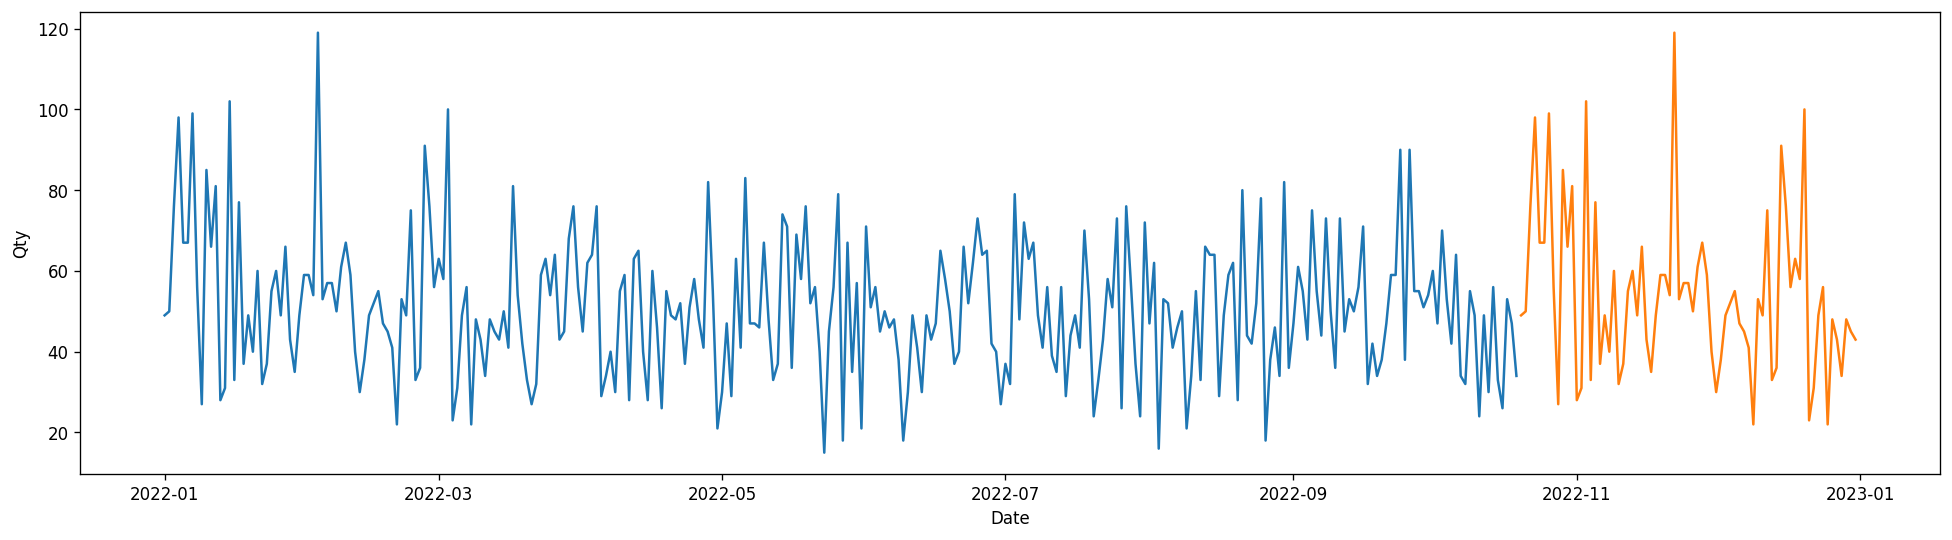

In [ ]:
#Plot data tarin dan data test
plt.figure(figsize=(20,5))
ans.lineplot(data=df_train, x=df_train['Date'],y=df_train['Qty'])
ans.lineplot(data=df_test, x=df_test['Date'],y=df_train['Qty'])

In [ ]:
#calculasi RMSE dan MAE
def rmse (y_actual, y_pred):
  print(f'RMSE Value{mean_squared_error(y_actual, y_pred)** 0.5}')

# fungsi MAE
def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE Value{mean_absolute_error(y_actual, y_pred)** 0.5}')


In [ ]:
# Fit ARIMA (0,0,0) seasonal (2,1,1)[7]
order = (0,0,0)
seasonal_order = (2,1,1,7)
model= sm.tsa.SARIMAX(df_train['Qty'],order = order, seasonal_order = seasonal_order)
fit_qty = model.fit()
print(fit_qty.summary())

                                 SARIMAX Results                                 
Dep. Variable:                       Qty   No. Observations:                  292
Model:             SARIMAX(2, 1, [1], 7)   Log Likelihood               -1221.516
Date:                   Sat, 02 Sep 2023   AIC                           2451.033
Time:                           15:03:46   BIC                           2465.643
Sample:                                0   HQIC                          2456.889
                                   - 292                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1162      0.070     -1.671      0.095      -0.253       0.020
ar.S.L14      -0.1665      0.072     -2.297      0.022      -0.309      -0.024
ma.S.L7       -0.8677      0

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
mod = ARIMA(df_train['Qty'], order=order)
res = mod.fit()
jlung = acorr_ljungbox(res.resid)

RMSE Value16.54736809215375
MAE Value3.706159741304183


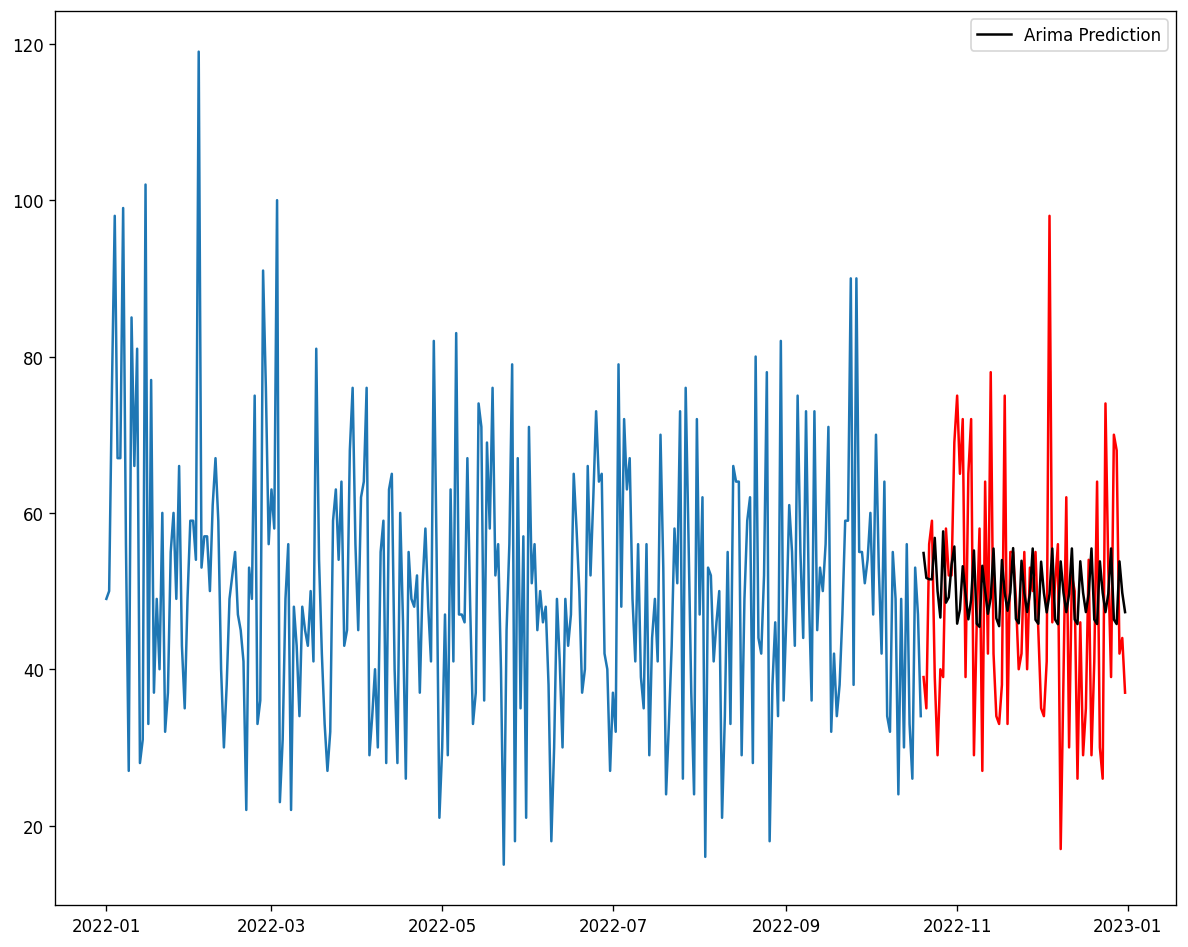

In [ ]:
# Prediksi model arima yang digunakan
# ARIMA (0,0,0) seasonal (2,1,1)[7]
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y_pred = fit_qty.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['prediction'] = fit_qty.predict(start = y_pred_df.index[0],end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['prediction']

eval(df_test['Qty'],y_pred_out)

plt.figure(figsize=(10,8))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'],color = 'red')
plt.plot(y_pred_out, color = 'black', label = 'Arima Prediction')

plt.legend()
plt.tight_layout()

In [ ]:
# Melakukan Forecast dari data yang digunakan selama satu bulan
forecast_length = 31
forecast_result = fit_qty.get_forecast(forecast_length)
forecast_result_arima = forecast_result.conf_int()
forecast_result_arima['forecasted Qty'] = fit_qty.predict(start = forecast_result_arima.index[0], end = forecast_result_arima.index[-1])
forecast_result_arima['Date'] = pd.date_range(start ='2023-01-01', end = '2023-01-31')
forecast_result_arima.set_index('Date', inplace = True)
forecast_result_arima.head()

,lower Qty,upper Qty,forecasted Qty
Date,,,
2023-01-01,21.183633,88.556758,54.870195
2023-01-02,17.992318,85.365443,51.678881
2023-01-03,17.828900,85.202003,51.515451
2023-01-04,17.815297,85.188400,51.501849
2023-01-05,23.121810,90.494913,56.808362


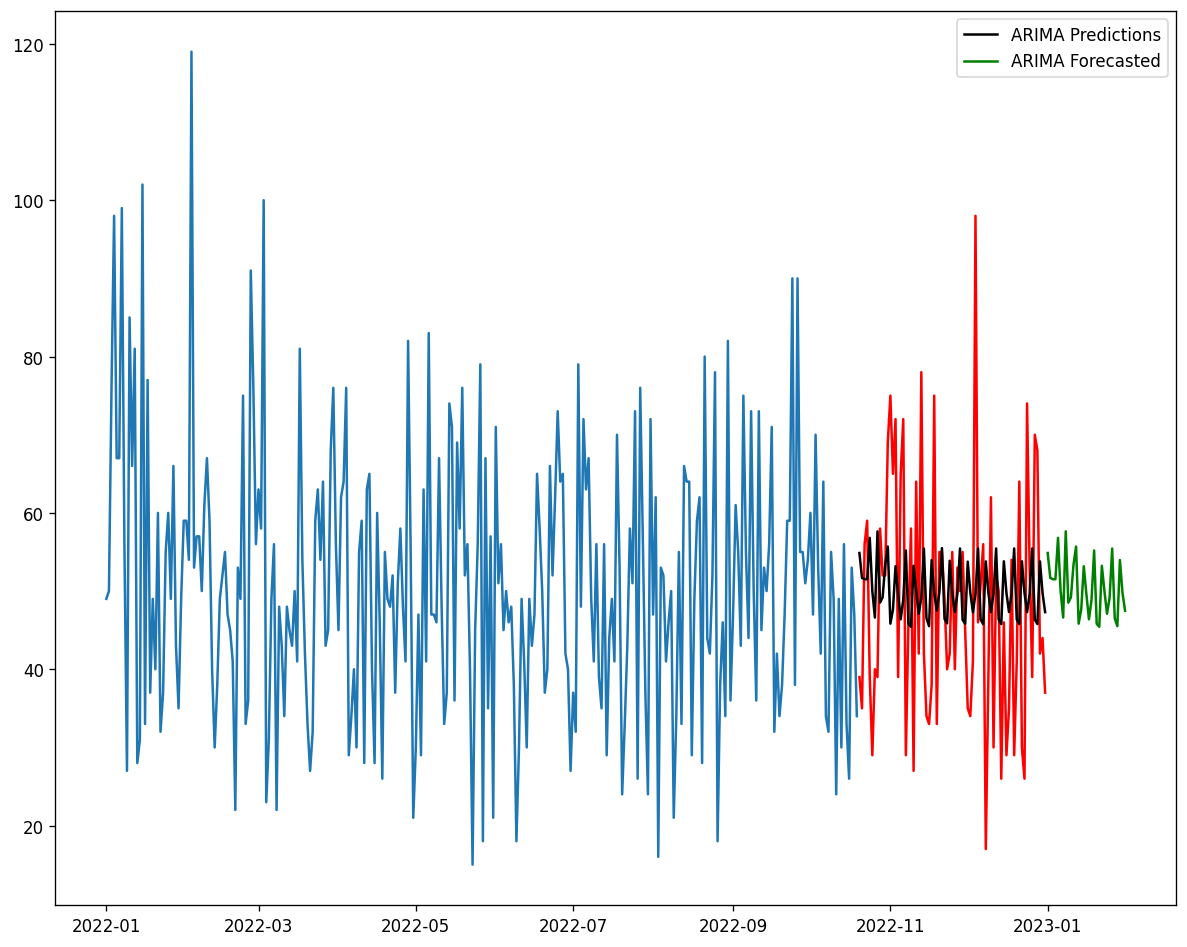

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(df_train[ 'Qty'])
plt.plot(df_test[ 'Qty'], color = 'red')
plt.plot(y_pred_out, color = 'black', label = 'ARIMA Predictions')
plt.plot(forecast_result_arima['forecasted Qty'], color = 'green', label = 'ARIMA Forecasted')
plt.legend()
plt.tight_layout()

## **Clustering**

 K-Means adalah salah satu metode yang paling umum digunakan dalam analisis klaster atau clustering dalam ilmu data dan statistik. Tujuannya adalah untuk mengelompokkan data menjadi klaster atau kelompok berdasarkan kesamaan atribut atau karakteristik tertentu. Kluster-kluster ini dibentuk dengan cara meminimalkan variasi (varians) dalam setiap kluster dan memaksimalkan variasi antar kluster.

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [ ]:
#identifikasi kolom dengan korelasi yang tinggi/ repundan
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,0.002278,-0.003122
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.015518,0.004385
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,1.000000,-0.395995
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,0.015951,-0.001183,0.004385,-0.395995,1.000000


In [ ]:
#melakukan clustering model
df_cluster = df_merge.groupby('CustomerID').agg({'TransactionID':
                                                 'count', 'Qty':'sum',
                                                 'TotalAmount':'sum'}).reset_index()
df_cluster.tail()

,CustomerID,TransactionID,Qty,TotalAmount
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300
446,447,13,42,439300


-> Normalisasi data dalam clustering K-Means adalah langkah penting dalam
persiapan data sebelum menerapkan algoritma K-Means. Normalisasi bertujuan untuk mengubah rentang nilai atribut atau fitur dalam data agar memiliki skala yang seragam, sehingga semua atribut memiliki pengaruh yang seimbang dalam proses clustering. Tanpa normalisasi, atribut dengan skala yang besar atau varian yang tinggi akan mendominasi dalam pembentukan kluster, yang dapat menghasilkan hasil yang bias. DIsini saya menggunakna Min-Max Scaling: Ini adalah salah satu metode normalisasi yang paling umum. Min-Max scaling mengubah setiap atribut sehingga nilainya berada dalam rentang [0, 1],

In [ ]:
#Normalisasi Data
df_normalis= df_cluster.drop('CustomerID',axis = 1)
normalis = df_normalis.columns

df_normalisasi = MinMaxScaler().fit_transform(df_normalis)
df_normalisasi = pd.DataFrame(data = df_normalisasi, columns=normalis)

df_normalisasi.head()

,TransactionID,Qty,TotalAmount
0,0.777778,0.724638,0.703949
1,0.555556,0.681159,0.397827
2,0.666667,0.666667,0.469255
3,0.388889,0.521739,0.278823
4,0.222222,0.246377,0.233899


Elbow Method adalah salah satu teknik yang digunakan untuk memilih jumlah kluster yang optimal dalam algoritma clustering, seperti K-Means. Tujuannya adalah untuk menemukan jumlah kluster yang paling sesuai dengan struktur data yang ada.
langkah langkah elbow method
1. Pilih Rentang Jumlah Kluster: Langkah pertama adalah menentukan rentang jumlah kluster yang akan Anda coba. Anda biasanya memulai dengan jumlah kluster yang rendah, misalnya 2 kluster, dan meningkatkannya secara bertahap hingga jumlah kluster tertentu, yang mungkin mencakup sebagian besar data Anda.

2. Hitung Inertia (Within-Cluster Sum of Squares): Untuk setiap jumlah kluster dalam rentang yang Anda tentukan, jalankan algoritma clustering (misalnya, K-Means) dan hitung nilai inertia atau dalam-cluster sum of squares. Inertia adalah jumlah kuadrat jarak antara setiap data dalam kluster dengan pusat klusternya. Ini mengukur seberapa kompak kluster-kelompoknya. Nilai inertia lebih rendah menunjukkan bahwa data dalam kluster lebih erat terkumpul.

3. Plot Nilai Inertia: Buat grafik yang menunjukkan jumlah kluster pada sumbu X dan nilai inertia pada sumbu Y. Ini akan menghasilkan grafik yang menyerupai lengan manusia.

4. Identifikasi "Elbow": Lihat grafik nilai inertia. Pada awalnya, nilai inertia akan menurun seiring dengan peningkatan jumlah kluster. Namun, pada suatu titik, penurunan akan melambat, dan grafik akan membentuk kurva seperti siku (elbow). Titik ini disebut "elbow point."

5. Pilih Jumlah Kluster Optimal: Jumlah kluster optimal dipilih berdasarkan grafik elbow. Ini adalah jumlah kluster di mana penurunan nilai inertia tidak lagi signifikan atau lambat. Biasanya, jumlah kluster optimal adalah jumlah kluster yang terletak di sekitar siku grafik elbow. Ini adalah jumlah kluster yang mempertahankan keseimbangan antara kompaknya kluster (rendahnya inertia) dan jumlah kluster yang terlalu banyak.

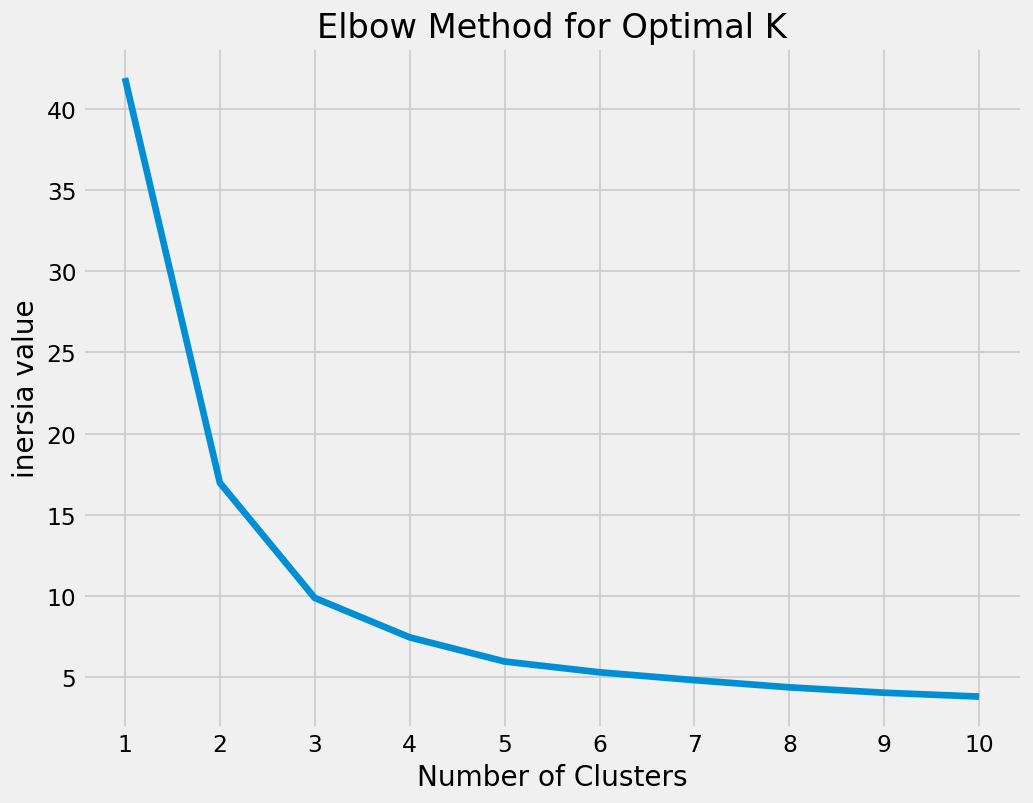

In [ ]:
#Implementasi menggunakn elbow method
inersia_value = []
k_value = range(1, 11)

for k in k_value:
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(df_normalisasi)
  inersia_value.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), inersia_value)
plt.xticks(range(1, 11))
plt.title('Elbow Method for Optimal K')
plt.xlabel("Number of Clusters")
plt.ylabel("inersia value")
plt.show()

In [ ]:
# Menentukan nilai K dengan elbow method secara otomatis
kl = KneeLocator(range(1, 11), inersia_value, curve="convex", direction="decreasing" )
kl.elbow


3

Silhouette Coefficient adalah metrik evaluasi yang digunakan untuk mengukur seberapa baik objek-objek dalam kluster telah dikelompokkan dengan baik dalam analisis clustering. Metrik ini membantu dalam menilai kualitas klustering dengan memberikan skor untuk setiap data point berdasarkan seberapa baik data tersebut dikelompokkan dengan anggota kluster lainnya dibandingkan dengan kluster lainnya.

Skor Silhouette Coefficient berkisar antara -1 hingga +1, dan hasil interpretasinya adalah sebagai berikut:

1. Nilai positif mendekati +1: Ini menunjukkan bahwa objek dalam kluster tersebut dikelompokkan dengan sangat baik, dengan sedikit atau tanpa tumpang tindih dengan kluster lainnya.

2. Nilai nol: Ini menunjukkan bahwa objek tersebut berada tepat pada batas antara dua kluster yang berdekatan atau memiliki kesulitan dalam menentukan kluster yang sesuai.

3. Nilai negatif mendekati -1: Ini menunjukkan bahwa objek tersebut mungkin ditempatkan dalam kluster yang salah dan lebih baik jika ditempatkan dalam kluster lain.

Keuntungan penggunaan Silhouette Coefficient adalah kemampuannya untuk memberikan informasi tentang seberapa baik klustering telah dilakukan tanpa memerlukan pengetahuan sebelumnya tentang label kelas sebenarnya (dalam metode unsupervised learning).

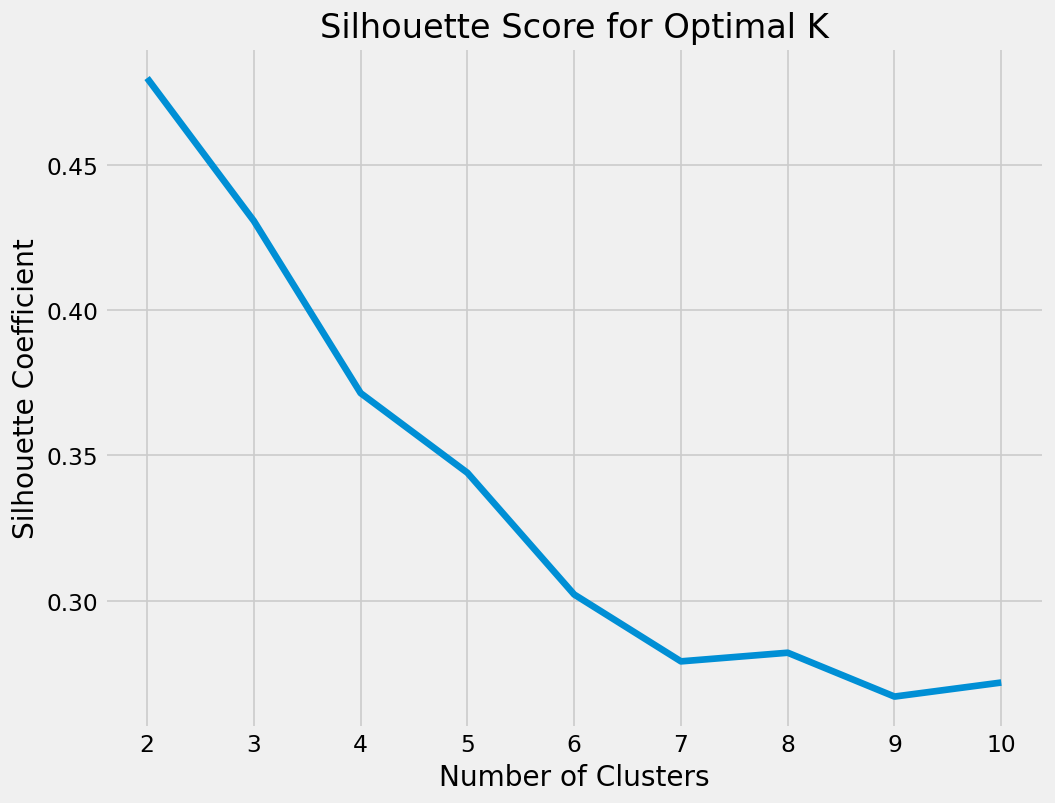

In [ ]:
# mencari nilai Silhouette Coefficient
silhouette_value = []
k_value = range(2, 11)

# Notice you start at 2 clusters for silhouette coefficient
for k in k_value:
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(df_normalisasi)
  score = silhouette_score(df_normalisasi, kmeans.labels_)
  silhouette_value.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_value)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for Optimal K')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Clustering dengan menggunakna K=3 dan K= 7 kemudian diplih hasil yang paling bagus diantara keduanya

In [ ]:
# Clustering dengan K = 3
kmeans = KMeans(n_clusters=3, random_state=0)
df_cluster['Cluster']= kmeans.fit_predict(df_cluster)
df_kmean3 = df_cluster
df_kmean3.head(10)

,CustomerID,TransactionID,Qty,TotalAmount,Cluster
0,1,17,60,623300,0
1,2,13,57,392300,1
2,3,15,56,446200,1
3,4,10,46,302500,2
4,5,7,27,268600,2
5,6,10,44,459100,1
6,7,17,57,498800,0
7,8,14,47,542100,0
8,9,10,44,349200,1
9,10,14,50,478000,0


In [ ]:
# Calculate the mean for each column grouped by 'Cluster'
cluster_means = df_kmean3.groupby('Cluster')[['TransactionID', 'Qty', 'TotalAmount']].mean()

# Display the calculated means
cluster_means.head()

,TransactionID,Qty,TotalAmount
Cluster,,,
0,15.322222,58.088889,548162.222222
1,11.752688,42.779570,384003.225806
2,8.508772,29.888889,241425.730994


Hasil jumlah, total, mean, median, dan std untuk masing masing cluster 0,1,2 dari TransaksiID, QTY dan Total Amount

In [ ]:
# Group the data by 'Cluster' and calculate count, sum, mean, median, and standard deviation
cluster_summary = df_kmean3.groupby('Cluster')[['TransactionID', 'Qty', 'TotalAmount']].agg(
    {'TransactionID': ['count', 'sum', 'mean', 'median', 'std'],
     'Qty': ['count', 'sum', 'mean', 'median', 'std'],
     'TotalAmount': ['count', 'sum', 'mean', 'median', 'std']}
)

# Rename the columns for clarity
cluster_summary.columns = ['TransactionID_Count', 'TransactionID_Sum', 'TransactionID_Mean', 'TransactionID_Median', 'TransactionID_Std',
                            'Qty_Count', 'Qty_Sum', 'Qty_Mean', 'Qty_Median', 'Qty_Std',
                            'TotalAmount_Count', 'TotalAmount_Sum', 'TotalAmount_Mean', 'TotalAmount_Median', 'TotalAmount_Std']
cluster_summary.head()

,TransactionID_Count,TransactionID_Sum,TransactionID_Mean,TransactionID_Median,TransactionID_Std,Qty_Count,Qty_Sum,Qty_Mean,Qty_Median,Qty_Std,TotalAmount_Count,TotalAmount_Sum,TotalAmount_Mean,TotalAmount_Median,TotalAmount_Std
Cluster,,,,,,,,,,,,,,,
0,90,1379,15.322222,15.0,2.134930,90,5228,58.088889,57.0,7.774410,90,49334600,548162.222222,528850.0,70435.131648
1,186,2186,11.752688,12.0,1.937711,186,7957,42.779570,42.0,7.013486,186,71424600,384003.225806,383800.0,42092.441259
2,171,1455,8.508772,9.0,2.132020,171,5111,29.888889,30.0,7.715107,171,41283800,241425.730994,250000.0,52225.981070


In [ ]:
#jumlah customer tiap cluster :
Customer_count3 = df_cluster['Cluster'].value_counts()
print('Jumlah customer tiap cluster adalah')
print(Customer_count3)

Jumlah customer tiap cluster adalah
1    186
2    171
0     90
Name: Cluster, dtype: int64


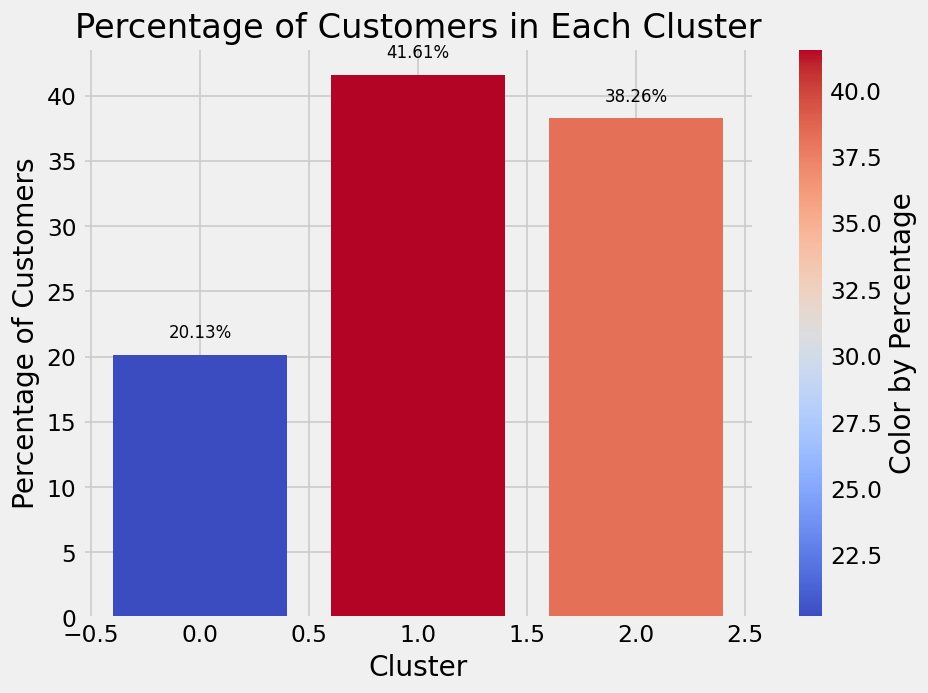

In [ ]:
# Presentasi jumlah customer tiap clusternya.
percentage_customer_count = (Customer_count3 / Customer_count3.sum()) * 100

# Create a colormap based on the percentage values
cmap = plt.get_cmap('coolwarm')
normalize = Normalize(vmin=percentage_customer_count.min(), vmax=percentage_customer_count.max())
colors = [cmap(normalize(value)) for value in percentage_customer_count]

# Plot the percentages with colored bars
plt.figure(figsize=(8, 6))
bars = plt.bar(percentage_customer_count.index, percentage_customer_count, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Customers')
plt.title('Percentage of Customers in Each Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Add percentage labels on top of each bar
for bar, value in zip(bars, percentage_customer_count):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

# Add color legend
sm = ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Color by Percentage')

plt.tight_layout()
plt.show()




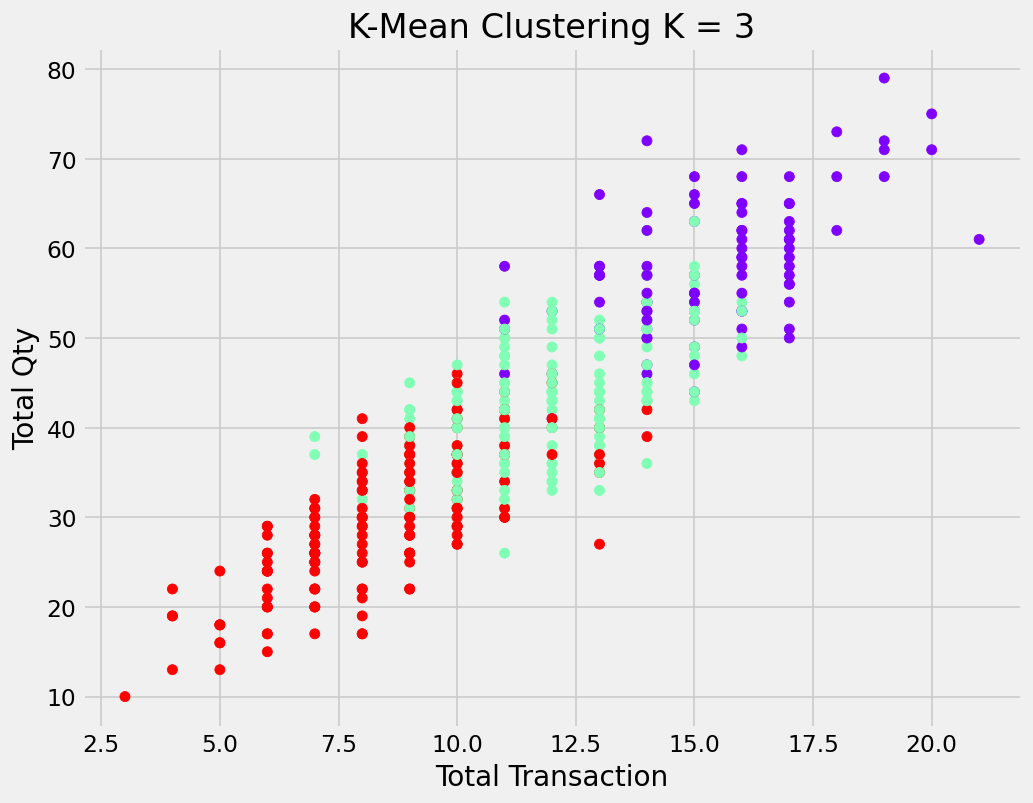

In [ ]:
# memvisiluasikan data
plt.scatter(df_kmean3['TransactionID'],df_kmean3['Qty'],c = df_kmean3['Cluster'], cmap ='rainbow')
plt.xlabel('Total Transaction')
plt.ylabel('Total Qty')
plt.title('K-Mean Clustering K = 3')
plt.show()

In [ ]:
#Cluster Kmean dengan K = 7
kmeans = KMeans(n_clusters=8, random_state=0)
df_cluster['Cluster']= kmeans.fit_predict(df_cluster)
df_kmean7 = df_cluster
df_kmean7.head(10)

,CustomerID,TransactionID,Qty,TotalAmount,Cluster
0,1,17,60,623300,5
1,2,13,57,392300,7
2,3,15,56,446200,3
3,4,10,46,302500,1
4,5,7,27,268600,6
5,6,10,44,459100,3
6,7,17,57,498800,0
7,8,14,47,542100,0
8,9,10,44,349200,7
9,10,14,50,478000,0


In [ ]:
#jumlah customer tiap cluster :
Customer_count = df_kmean7['Cluster'].value_counts()
print('Jumlah customer tiap cluster adalah')
print(Customer_count)

Jumlah customer tiap cluster adalah
7    87
1    87
6    70
3    68
0    55
2    45
5    32
4     3
Name: Cluster, dtype: int64


Hasil jumlah, total, mean, median, dan std untuk masing masing cluster 0,1,2 dari TransaksiID, QTY dan Total Amount

In [ ]:
# Group the data by 'Cluster' and calculate count, sum, mean, median, and standard deviation
cluster_summary = df_kmean7.groupby('Cluster')[['TransactionID', 'Qty', 'TotalAmount']].agg(
    {'TransactionID': ['count', 'sum', 'mean', 'median', 'std'],
     'Qty': ['count', 'sum', 'mean', 'median', 'std'],
     'TotalAmount': ['count', 'sum', 'mean', 'median', 'std']}
)

# Rename the columns for clarity
cluster_summary.columns = ['TransactionID_Count', 'TransactionID_Sum', 'TransactionID_Mean', 'TransactionID_Median', 'TransactionID_Std',
                            'Qty_Count', 'Qty_Sum', 'Qty_Mean', 'Qty_Median', 'Qty_Std',
                            'TotalAmount_Count', 'TotalAmount_Sum', 'TotalAmount_Mean', 'TotalAmount_Median', 'TotalAmount_Std']
cluster_summary.head(8)

,TransactionID_Count,TransactionID_Sum,TransactionID_Mean,TransactionID_Median,TransactionID_Std,Qty_Count,Qty_Sum,Qty_Mean,Qty_Median,Qty_Std,TotalAmount_Count,TotalAmount_Sum,TotalAmount_Mean,TotalAmount_Median,TotalAmount_Std
Cluster,,,,,,,,,,,,,,,
0,55,804,14.618182,15.0,1.890433,55,3013,54.781818,55.0,6.355782,55,27735100,504274.545455,499700.0,23986.587442
1,87,895,10.287356,10.0,1.648876,87,3165,36.379310,37.0,5.138187,87,26542900,305090.804598,304200.0,17204.161423
2,45,286,6.355556,6.0,1.509900,45,974,21.644444,22.0,5.023380,45,7611100,169135.555556,174000.0,29304.011171
3,68,873,12.838235,13.0,1.808853,68,3196,47.000000,45.5,6.366892,68,29234100,429913.235294,425350.0,19168.926226
4,3,59,19.666667,20.0,0.577350,3,225,75.000000,75.0,4.000000,3,2358700,786233.333333,760600.0,52567.321915
5,32,516,16.125000,16.0,1.862187,32,1990,62.187500,62.5,6.140492,32,19240800,601275.000000,587650.0,35333.042198
6,70,601,8.585714,8.0,1.628486,70,2096,29.942857,29.5,5.513845,70,17162100,245172.857143,245800.0,18057.813126
7,87,986,11.333333,11.0,1.654217,87,3637,41.804598,41.0,5.852527,87,32158200,369634.482759,367800.0,17870.228767


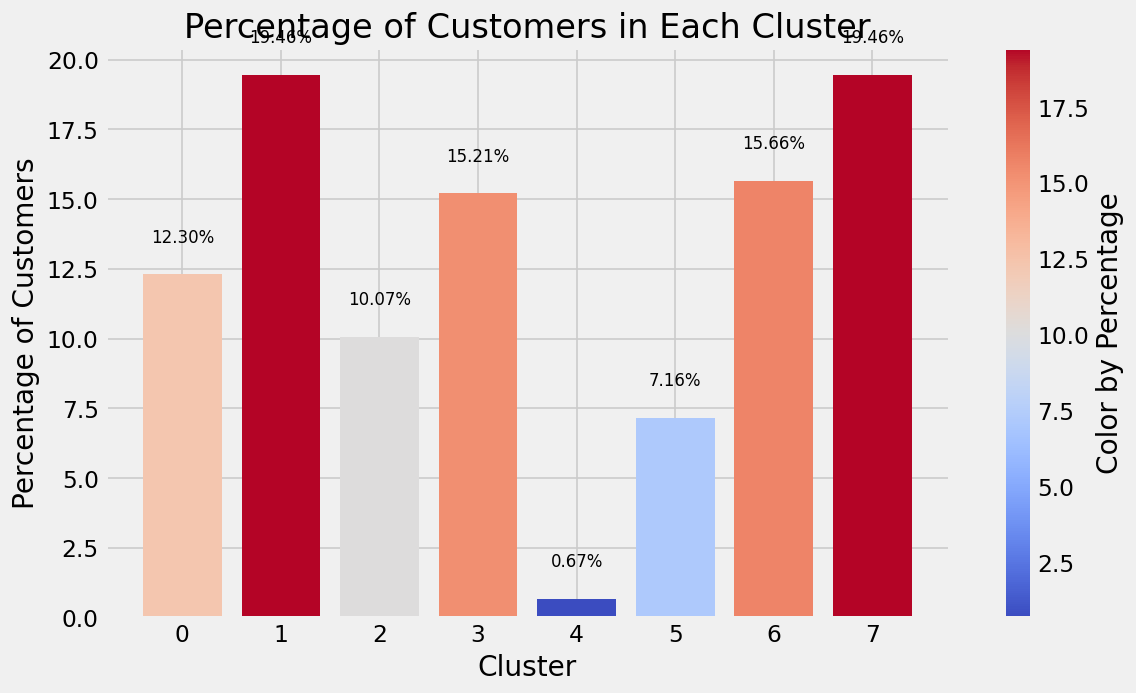

In [ ]:
#Presentasi jumlah Customer tiap clusternya
percentage_customer_count = (Customer_count / Customer_count.sum()) * 100

# Create a colormap based on the percentage values
cmap = plt.get_cmap('coolwarm')
normalize = Normalize(vmin=percentage_customer_count.min(), vmax=percentage_customer_count.max())
colors = [cmap(normalize(value)) for value in percentage_customer_count]

# Plot the percentages with colored bars
plt.figure(figsize=(10, 6))
bars = plt.bar(percentage_customer_count.index, percentage_customer_count, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Customers')
plt.title('Percentage of Customers in Each Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed

# Add percentage labels on top of each bar
for bar, value in zip(bars, percentage_customer_count):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

# Add color legend
sm = ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Color by Percentage')

plt.tight_layout()
plt.show()


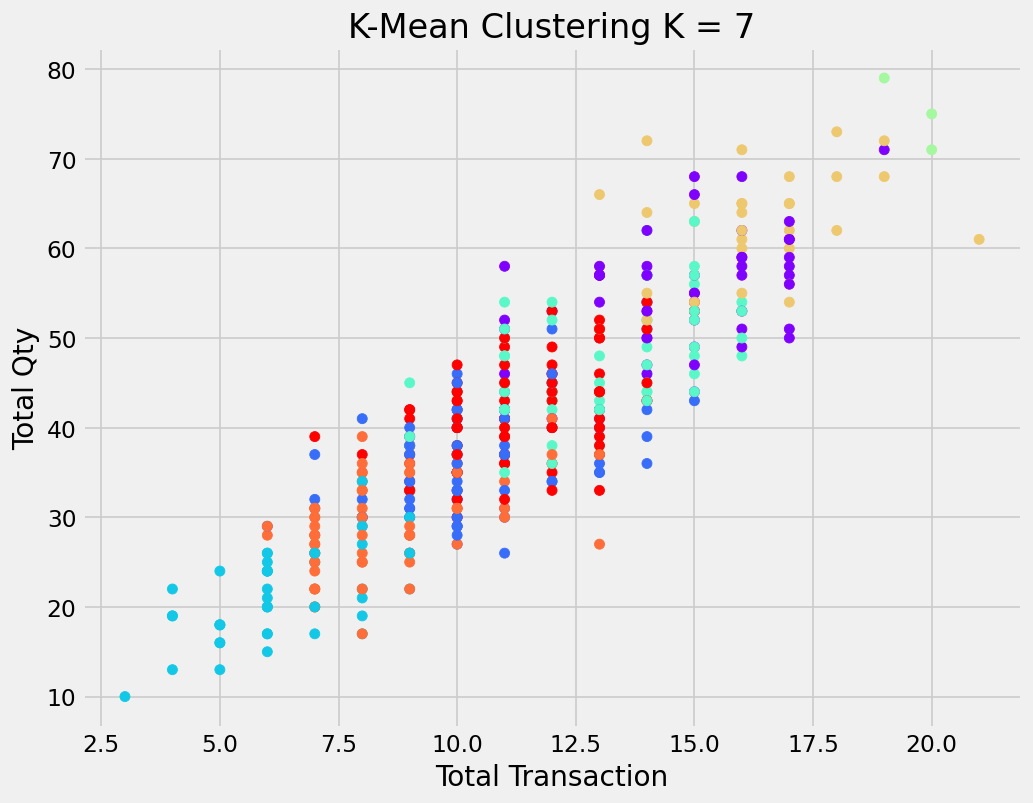

In [ ]:
# memvisiluasikan data
plt.scatter(df_kmean7['TransactionID'],df_kmean7['Qty'],c = df_kmean7['Cluster'], cmap ='rainbow')
plt.xlabel('Total Transaction')
plt.ylabel('Total Qty')
plt.title('K-Mean Clustering K = 7')
plt.show()

**Cluster Interpretasi**

Berdasarkan Cluster yang dipilih yaitu 3 dapat disimpulkan dan dikelompokkan berdasarkan Clusternya yaitu :

1. Cluster 0 -  Customer Legend
   Merupakan customer dengan tier menengah dengan total Customer sebanyak 90 Customer atau sekitar 20,13% dengan rata rata transaksi sebanyak 15 kali, sedangkan total kualitas produk yang di beli yaitu 58 produk dan rata rata jumlah uang yang di gunakan yaitu sekitar 548k dan total uang yang digunakan yaitu 49 juta
2. Cluster 1 - Customer Mytic
   Merupakan customer dengan tier tertinggi dengan total Customer sebanyak 186 Customer atau sekitar 41,61% dengan rata rata transaksi sebanyak 11 kali, sedangkan total kualitas produk yang di beli yaitu 42 produk dan rata rata jumlah uang yang di gunakan yaitu sekitar 348k dan total uang yang digunakan yaitu 71 juta
3. Cluster 2 - Customer Epic
	 Merupakan customer dengan tier bawah dengan total Customer sebanyak 171 Customer atau sekitar 38,26% dengan rata rata transaksi sebanyak 8 kali, sedangkan total kualitas produk yang di beli yaitu 29 produk dan rata rata jumlah uang yang di gunakan yaitu sekitar 241k dan total uang yang digunakan yaitu 41 juta.

 ** Business Recommendation**

1. Customer Epic 	: Memberikan promo atau diskon pada saat awal melakukan belanja agar terkesan serta memberikan pelayana yang baik. Apabila customer jarang melakukan transaksi bisa mengirimkan email atau sebuah pemberitahuan mengenai promo promo yang sedang berlangsung serta memberi ucapan atau caption yang menarik agar pembeli kembali untuk membeli barang.  

2. Customer Legend 	: Pada tier ini customer bisa menjadi customer Mytic ataupun customer Epic. Dengan memberikan diskon atau penawaran ekslusif dengan waktu terbatas agar customer dapat berberlanja lebih sering serta memberikan poin atau reward yang dapat di tukarkan menjadi sebuah diskon tambahan atau dapat disimpan. Mengirimkan notifikasi tentang penawaran produk terkini dan memberikan ucapan untuk menarik membeli barang.

3. Customer Mytic 	: Merupakan tier paling tinggi dengan berbagai keuntungan seperti mendapat diskon yang lebih beragam dari tier yang lain, memiliki penawaran khusus, serta memberikan point yang dapat dikumpulkan atau di tukar serta akses untuk produk produk terbaru yang belum di luncurkan dan ekslusif memberikan pelayanan yang sangat baik baik dari ruangan atau dari pelayannya.

